In [1]:
import sys
sys.path.insert(0,'../scripts')
import plot_settings
from plot_settings  import palette

In [ ]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import bootstrap
import pandas as pd
from tqdm import tqdm
from utils import re1, re2
import os
import re


method_dict = {
    ("H1", "H6", 0.0, 1.0): "Annealed Potential",
    ("H4", "H6", 0.0, 0.0): "Static Potential",
    ("H1", "H6", 1.0, 0.0): "Annealed SHIL",
    ("H1", "H6", 0.0, 0.0): "None",
}
distributions = {}
# Get the phase distributions for each type of binarization strategy
comp_distributions = {"Annealed Potential": [], "Static Potential": [], "Annealed SHIL": [], "None": []}

# Data files are in `data_full`, job launch params are in `parameters_full`
for pathd, pathp in [('../data/data_full', '../data/parameters_full')]:
    records = pd.read_csv(f'{pathp}/records.csv')
    for dfile in os.listdir(pathd):
        job = int(re.findall(r'(\d+)\.run', dfile)[0])
        with open(f"{pathd}/{dfile}") as inputfile:
            instring = inputfile.read()
            final_phase = np.array([float(i)+1j*float(j) for i, j in re1.findall(instring)])
            energy, state = re2.findall(instring)[0]
            state = state.replace("-1", " 0").replace(" ", "")
        quad,cube, shil,anneal_power  = records.query(f'job == {job}')[['quadratic-model', 'cubic-model', 'shil-coeff', 'anneal-power']].to_records(index=False)[0]
        # Get the method label string
        method = method_dict.get((quad, cube, shil,anneal_power), None)
        # If recognized, add it to the output data structure
        if method is not None:
            comp_distributions[method].append(final_phase)


In [5]:
def format_radians_label(float_in):
    # Converts a float value in radians into a
    # string representation of that float
    string_out = str(float_in / (np.pi))+"π"
    
    return string_out

def convert_polar_xticks_to_radians(ax):
    # Converts x-tick labels from degrees to radians
    
    # Get the x-tick positions (returns in radians)
    label_positions = ax.get_xticks()
    
    # Convert to a list since we want to change the type of the elements
    labels = list(label_positions)
    
    # Format each label (edit this function however you'd like)
    labels = [format_radians_label(label) for label in labels]
    
    ax.set_xticklabels(labels)
    ax.tick_params(pad=25)

/tmp/ipykernel_299193/3674309815.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels)
/tmp/ipykernel_299193/3674309815.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels)
/tmp/ipykernel_299193/3674309815.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels)
/tmp/ipykernel_299193/3674309815.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels)


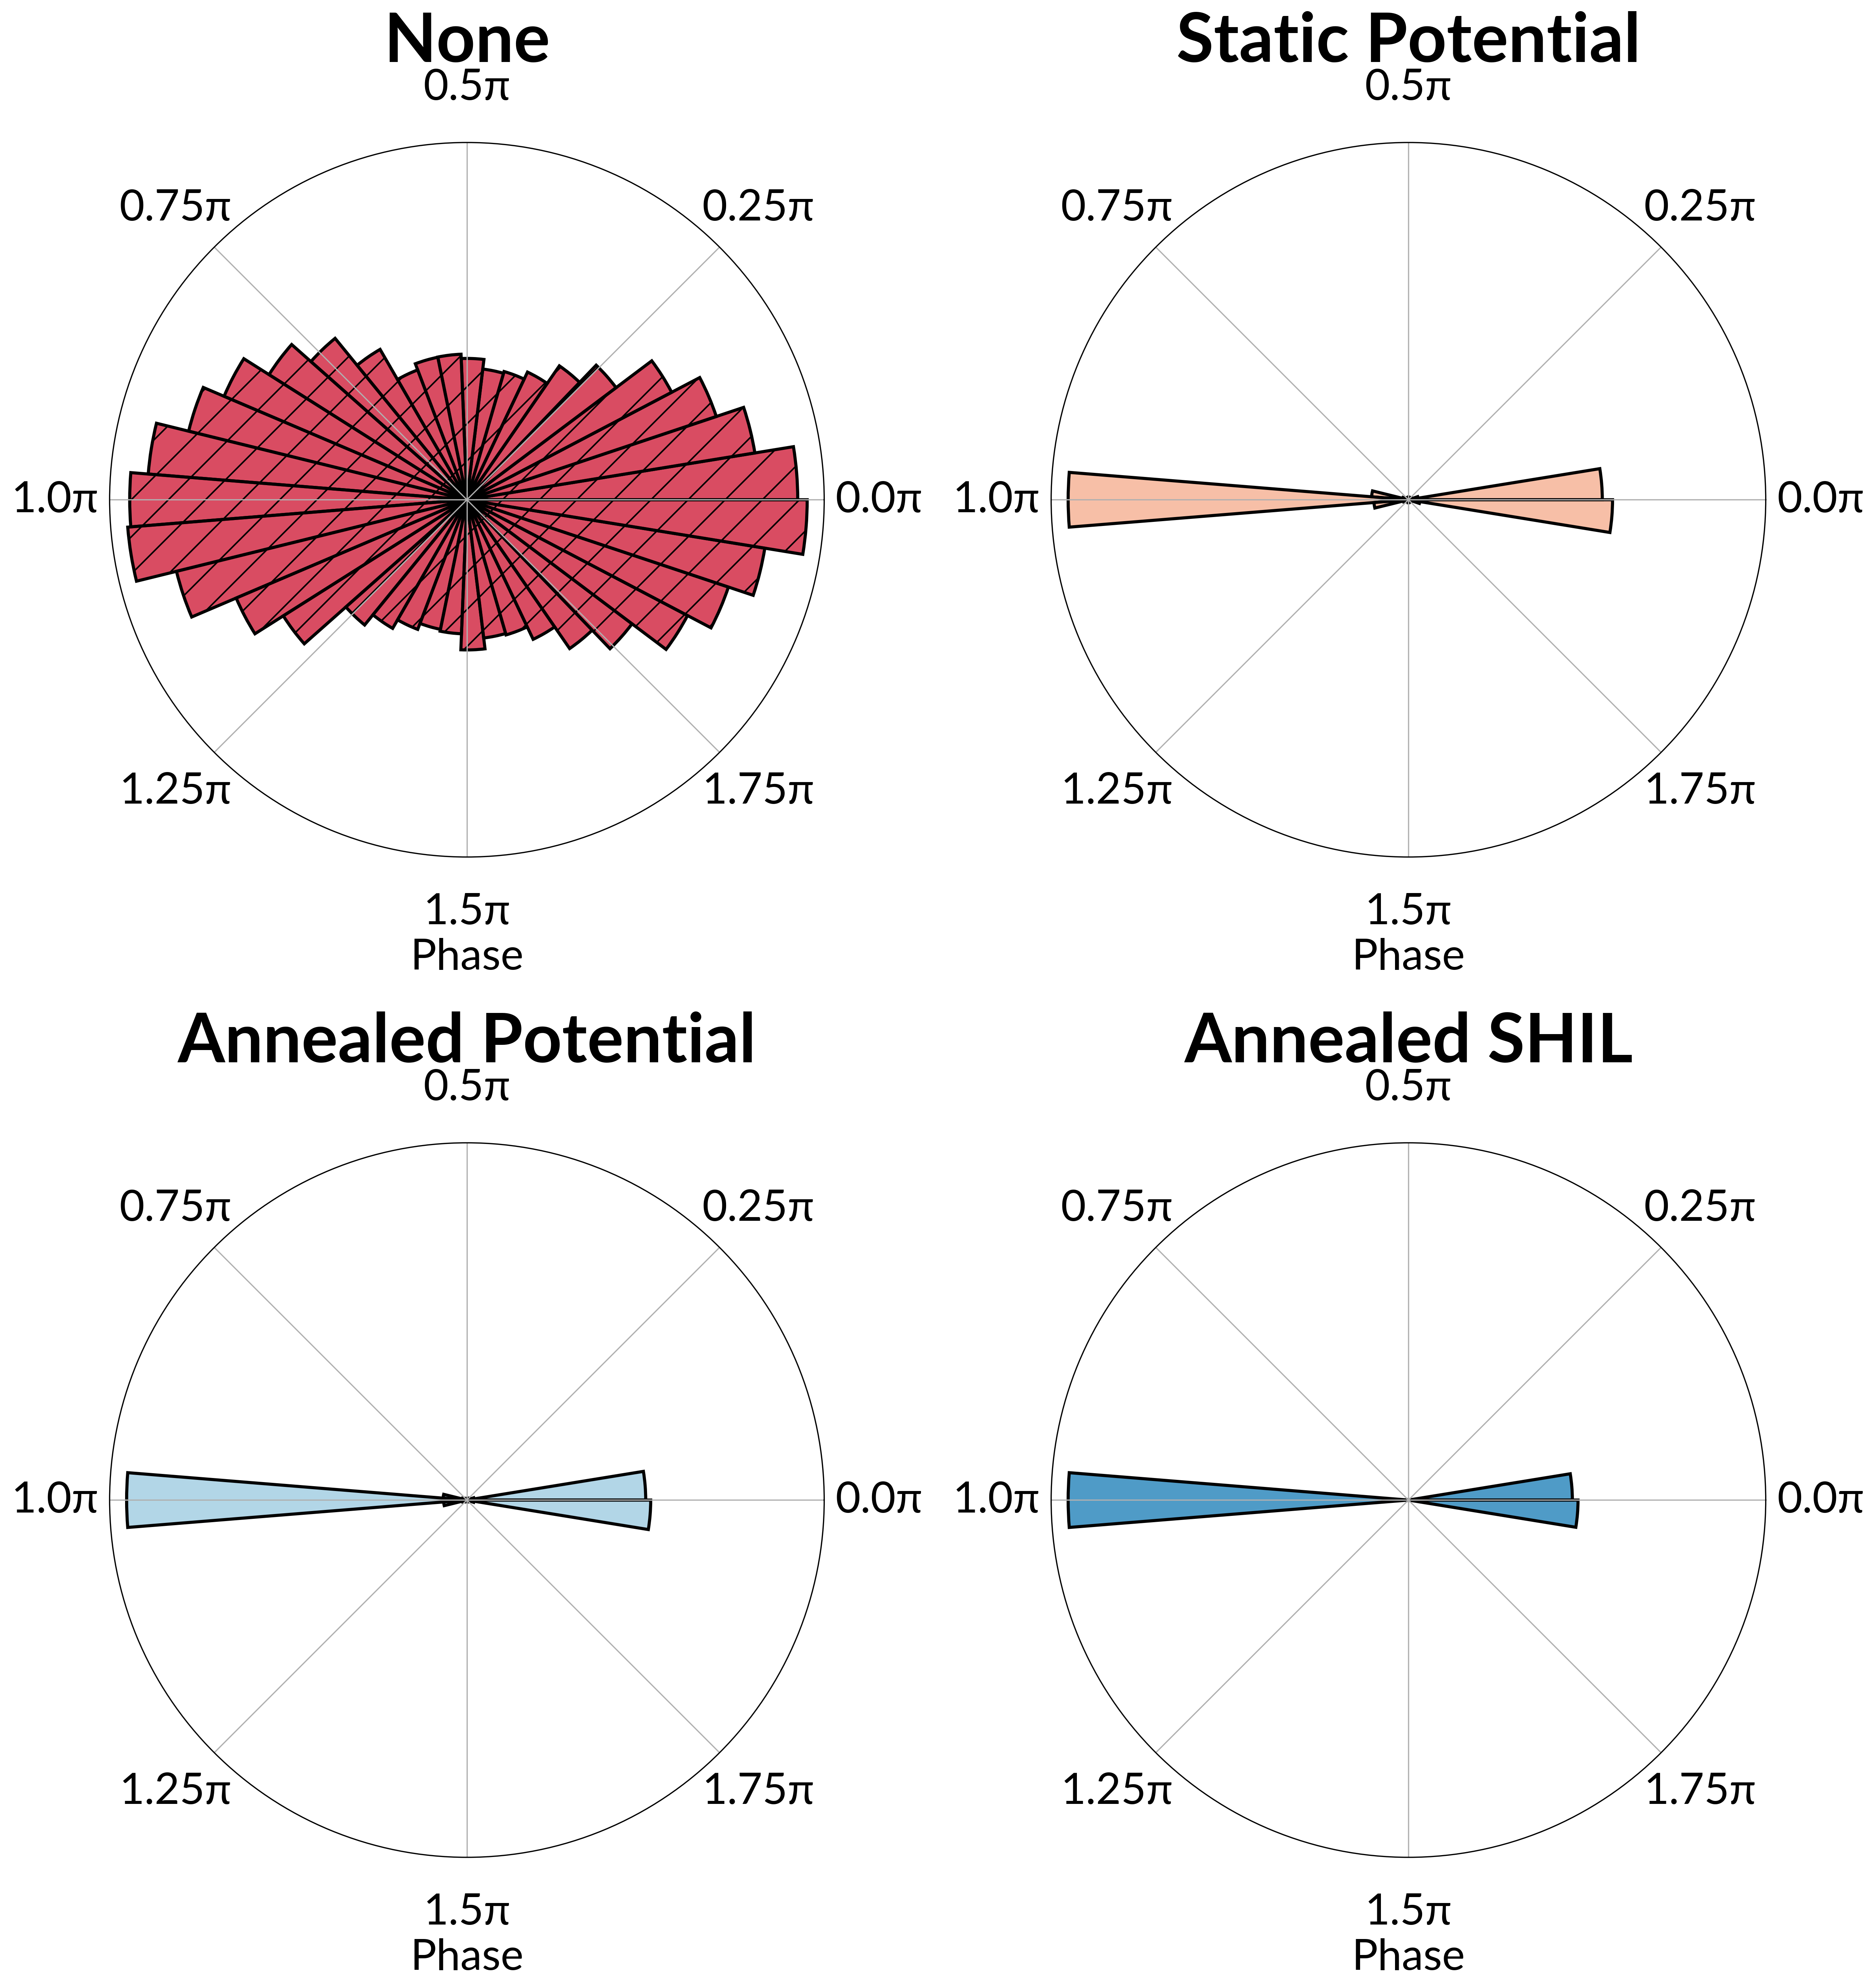

In [ ]:
bins = np.linspace(0, 2 * np.pi, 40)
fig, axs = plt.subplot_mosaic([['None', 'Static Potential'],
                               ['Annealed Potential', 'Annealed SHIL']], figsize=(20, 20), subplot_kw=dict(projection='polar'), gridspec_kw=dict(wspace=0.2,hspace=0.4))
ddict = {"Method": []} | dict([(i, []) for i in bins[:-1]])
mvalues = []
labels = []
plot_dict = {}
# Get the polar phase value
for i in comp_distributions:
    z = comp_distributions[i]
    real = np.real(z)
    imag = np.imag(z)
    mag = np.sqrt(real * real + imag * imag)
    phase = np.arccos(real / mag)
    phase[np.arcsin(imag / mag) < 0] += np.pi
    phase = phase
    values = np.concatenate(phase)
    hist = np.histogram(values, bins=bins)[0]
    ddict['Method'].append(i)
    for ind, j in enumerate(bins[:-1]):
        ddict[j].append(hist[ind])
    labels.append([i] * len(values))
    plot_dict[i] = values
    mvalues.append(values)

# Plot each phase as a polar plot
labels = np.concatenate(labels)
mvalues = np.concatenate(mvalues)
data = pd.DataFrame({"Method": labels, "Phase": mvalues})
for key, ax in axs.items():
    sns.histplot(data.query(f'Method ==\"{key}\"'), bins=bins, ax=axs[key], x='Phase', hue='Method', multiple='layer', 
                 hue_order=['None', 'Static Potential', 'Annealed Potential', 'Annealed SHIL'], alpha=0.7, palette=palette, linewidth=2)
    ax.set_ylabel('')
    ax.set_yticks([])
    ax.set_title(key, y=1.1, fontsize=44, weight='bold')
    ax.legend_ = None
    convert_polar_xticks_to_radians(ax)
hatches = ['/', '', 'o', 'x']

# Loop over the bars
for container, hatch in zip(axs['None'].containers, hatches):
    
    # iterate through each rectangle in the container
    for rectangle in container:

        # set the rectangle hatch
        rectangle.set_hatch(hatch)
fig.savefig('../figures/binarization_distribution.pdf', bbox_inches='tight')